In [1]:
import matplotlib.pyplot as plt
from glob import glob
from argparse import Namespace
from itertools import groupby
import data.eval as eval
import re
from collections import defaultdict
import pandas as pd

In [2]:
gold_files = glob('data/generated_samples/**/Gold/**/*.jsonl', recursive=True)
eval_files = glob('data/generated_samples/**/Eval/**/*.jsonl', recursive=True)


In [3]:
def get_model_df(grouped_results):
    results_arr = []

    for model, files in grouped_results:
        for file in files:
            epoch = re.match(r'.*_(?P<epoch>\d+)_.*', file).group(1)

            args = Namespace(
                results_path=file,
                dataset_path='data/instruct_cochrane_gold.json',
                label_field_name='gold_label',
                lines=True,
                rogue_tokens=True
            )

            results_df, _ = eval.main(args)
            results_df['model'] = model
            results_df['epoch'] = int(epoch)
            results_df.drop(index=['weighted avg'], columns='support', inplace=True)

            results_df.set_index(['model', 'epoch', results_df.index], inplace=True)

            results_arr.append(results_df)

    return pd.concat(results_arr).sort_index()

grouped_gold = groupby(sorted(gold_files, key=lambda x: x.split('/')[1]), lambda x: x.split('/')[1])
grouped_eval = groupby(sorted(eval_files, key=lambda x: x.split('/')[1]), lambda x: x.split('/')[1])

gold_df = get_model_df(grouped_gold)
eval_df = get_model_df(grouped_eval)

Index(['generated_samples'], dtype='object', name='model')
Axes(0.125,0.11;0.775x0.77)
                                   precision    recall  f1-score
model             epoch                                         
generated_samples 0     Excluded    0.500000  0.034483  0.064516
                        Included    0.728155  0.961538  0.828729
                        macro avg   0.614078  0.498011  0.446623
                        micro avg   0.723810  0.710280  0.716981
                  1     Excluded    0.274510  0.965517  0.427481
...                                      ...       ...       ...
                  15    macro avg   0.649697  0.661720  0.536401
                  18    Excluded    0.375000  0.931034  0.534653
                        Included    0.944444  0.430380  0.591304
                        accuracy    0.564815  0.564815  0.564815
                        macro avg   0.659722  0.680707  0.562979

[144 rows x 3 columns]


TypeError: 'Axes' object is not subscriptable

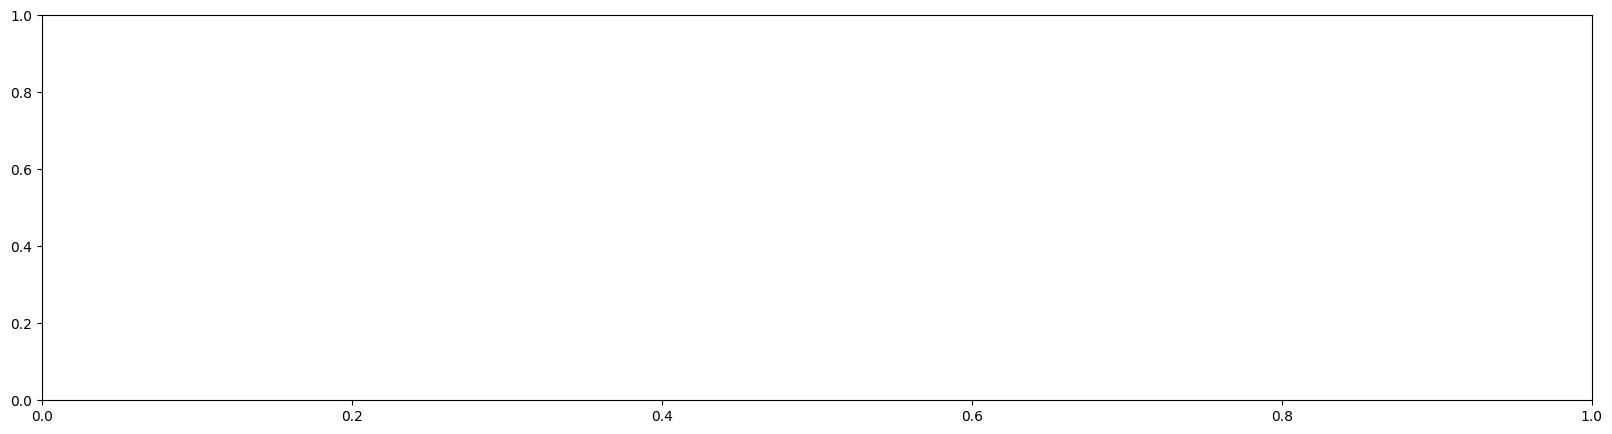

In [5]:
def plot_results(results_df, metric='f1-score'):
    models = results_df.index.get_level_values(0).unique()
    print(models)

    _, axs = plt.subplots(1, len(models), figsize=(20, 5))
    print(axs)

    for i, model in enumerate(models):
        print(results_df)
        #results_df.xs(model).unstack(level=1)[metric].plot(ax=axs[i])
        results_df.xs(model)[metric].plot(ax=axs[i])
        axs[i].set_title(model)
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(metric)

    plt.show()

plot_results(gold_df)